In [1]:
from train import trainer
import yaml
from models import ModelCollection
from dataset import GrepDataset
from torch.utils.data import DataLoader
import numpy as np

import sklearn
import numpy as np
import yaml
from models import ModelCollection
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def GenTransprob(product_num, lb_0 = 0.1, ub_0 = 0.2):
    potential_vec = np.random.uniform(low=0., high=1, size=product_num)
    prob_0 = np.random.uniform(low=lb_0, high=ub_0)

    prob_vec = potential_vec / max(sum(potential_vec), 1e-6) * (1-prob_0)
    prob_vec = np.insert(prob_vec, 0, 1- sum(prob_vec))
    return prob_vec

# zero out some elements
def GenTransprob_Even(product_num, lb_0 = 0.1, ub_0 = 0.2, lam = 1/2):
    potential_vec = np.random.uniform(low=0., high=1, size=product_num)
    potential_vec[potential_vec > lam] =0
    prob_0 = np.random.uniform(low=lb_0, high=ub_0)
    prob_vec = potential_vec / max(sum(potential_vec), 1e-6) * (1-prob_0)
    prob_vec = np.insert(prob_vec, 0, 1- sum(prob_vec))
    return prob_vec


# a sparse structure is less computational heavy, so further zero out some elements
def GenTransprob_Sparse(product_num, lb_0 = 0.1, ub_0 = 0.2, sparse_fun = lambda x : np.sqrt(x)):
    potential_vec = np.random.uniform(low=0., high=1, size=product_num)
    potential_vec[potential_vec > (sparse_fun(product_num) / product_num)] =0
    prob_0 = np.random.uniform(low=lb_0, high=ub_0)
    prob_vec = potential_vec / max(sum(potential_vec), 1e-6) * (1-prob_0)
    prob_vec = np.insert(prob_vec, 0, 1- sum(prob_vec))
    return prob_vec

def GenTranprob_Abundant(product_num, lb_0 = 0.1, ub_0 = 0.2):
    fixied = random.sample(list(range(1,product_num+1)),k=1)[0]
    return GenTransprob_Even(product_num, lb_0=lb_0, ub_0=ub_0, lam = fixied/product_num)




# generate transition matrix. Remember that 0 is absorbing and diagonal must be 0
def GenMarkovM(product_num, gen_func = lambda x : GenTransprob(x)):
    starting = np.zeros(product_num + 1)
    starting[0] = 1.0

    M = np.expand_dims(starting, axis = 0)

    for i in range(product_num):
        trans_vec = gen_func(product_num)

        M = np.concatenate((M,np.expand_dims(trans_vec,axis=0)), axis=0)

    for i in range(1,product_num+1):
        M[i,i]=0
        
    M = M / M.sum(axis=1, keepdims = True)
    return M

# probability vec to instance choice
def Pvec_to_Choice(p_vec):
    if not sum(p_vec) > 1.0 - 1e-6 and sum(p_vec) < 1.0 + 1e-6:
        print("WRONG PROBABILITY!")
        return
    index = np.random.choice(len(p_vec), 1, p=p_vec)[0]
    indicate = np.zeros(len(p_vec))
    indicate[index] = 1
    return indicate

# Note that, the arriving frequency Lams corresponds to each product
# but not product 0
# same is the case with Assort
# which does not contain product 0

def Absorbing_Calculator(Lams, TransP, Assorts):
    S_plus = np.squeeze(np.argwhere(Assorts == 1),axis=1)
    S_bar = np.squeeze(np.argwhere(Assorts == 0),axis=1)
    B = TransP[np.expand_dims(S_bar, axis=1), S_plus]
    C = TransP[np.expand_dims(S_bar, axis=1), S_bar]
    
    distri = np.zeros(len(Lams))
    
    addi = np.matmul(np.matmul(np.expand_dims(Lams[S_bar], axis=0), np.linalg.inv(np.identity(len(C)) - C)), B)
    
    count = 0
    for i in S_plus:
        distri[i] = Lams[i] + addi[0,count]
        count += 1
    
    return distri



class EM_MC:
    def __init__(self,samples_assort,samples_purchase,Markov_init='',lamb_init=''):
        def GenTransprob(product_num, lb_0 = 0.1, ub_0 = 0.2):
            potential_vec = np.random.uniform(low=0., high=1, size=product_num)
            prob_vec = potential_vec / max(sum(potential_vec), 1e-6)

            return prob_vec

        def GenMarkovM(product_num, gen_func = lambda x : GenTransprob(x)):

            M = np.zeros([product_num,product_num])
            for i in range(product_num):
                trans_vec = gen_func(product_num)
                M[i,:]=trans_vec

            M = M / M.sum(axis=1, keepdims = True)
            return M


        #initial rho, lambda as numpy narray. Samples are sample_num*item_num 
        #algorithms and notations follow https://pubsonline.informs.org/doi/suppl/10.1287/opre.2017.1692/suppl_file/opre.2017.1692-sm.pdf
        self.item_num=len(samples_assort[0])
        self.samp_num=len(samples_assort[:,0])
        self.samp_ass=samples_assort
        self.samp_pur=samples_purchase
        if len(Markov_init)==0:
            self.rho=GenMarkovM(self.item_num)
        else:
            self.rho=Markov_init
        if len(lamb_init)==0:
            self.lambd=GenTransprob(self.item_num)
        else:
            self.lambd=lamb_init
        self.itera_num=0

    def expect(self):
        self.F=[]
        self.X=[]
        for t in range(self.samp_num):
            pur_ind=np.where(self.samp_pur[t])[0].tolist()
            assS_index=(self.samp_ass[t]==1)
            assN_index=(self.samp_ass[t]==0)
            Theta_N_temp=np.matmul(np.linalg.inv(np.identity(sum(assN_index))- self.rho[assN_index][:,assN_index]),self.lambd[assN_index])
            Theta_temp=np.zeros(self.item_num)
            for i in np.where(assS_index)[0].tolist():
                Theta_temp[i]=self.lambd[i]+np.matmul(self.rho[np.where(assN_index),i],Theta_N_temp)[0]

            Theta_temp[assN_index]=Theta_N_temp
            
            Phi_N_temp=np.matmul(np.linalg.inv(np.identity(sum(assN_index))- self.rho[assN_index][:,assN_index]),self.rho[assN_index,pur_ind])
            Phi_S_temp=np.zeros(sum(assS_index))
            Phi_temp=np.insert(Phi_N_temp, np.where(assS_index)[0] - np.arange(len(np.where(assS_index)[0])), Phi_S_temp)
            Phi_temp[pur_ind]=1
            F_temp=Phi_temp*self.lambd/Theta_temp[pur_ind]
            X_temp=np.ones([self.item_num,self.item_num])
            for i in range(self.item_num):
                for j in range(self.item_num):
                     X_temp[i,j]=(self.samp_ass[t][i]==0)*Phi_temp[j]*self.rho[i,j]*Theta_temp[i]/Theta_temp[pur_ind]
            self.F.append(F_temp)
            self.X.append(X_temp)
    def maximiz(self):
        self.F=np.stack(self.F, axis=0)
        self.X=np.stack(self.X, axis=0)
        for i in range(self.item_num):
            self.lambd[i]=self.F[:,i].sum()/self.F.sum()
            for j in range(self.item_num):
                self.rho[i,j]=self.X[:,i,j].sum()/self.X[:,i,:].sum()
        #self.rho[0,:]=np.zeros(self.item_num)
        #self.rho[0,0]=1
    def perturb(self,t):
        self.rho=self.rho+2/(t+1)**0.5*np.random.uniform(size=[self.item_num,self.item_num])
        for i in range(self.item_num):
            self.rho[i]=self.rho[i]/self.rho[i].sum()
        self.lambd=self.lambd+2/(t+1)**0.5*np.random.uniform(size=self.item_num)
        self.lambd=self.lambd/sum(self.lambd)


def MC_EMtrain(INPUT,SAMP_OUTPUT,Markov_init='',lamb_init='',perturb=0,steps=250,break_thr=0.0001):
        MC_E=EM_MC(INPUT,SAMP_OUTPUT,Markov_init,lamb_init)
        if perturb>0:
            MC_E.perturb(perturb)#purturb the initial Markov_init and lamb_init if needed
        loss_l=[]
        for t in range(steps):
            temp=MC_E.rho
            MC_E.expect()
            MC_E.maximiz()
            print(t)
            Vec_Len = MC_E.item_num
            SAMPLE_AMOUNT=MC_E.samp_num


            PROB_PRED = np.zeros((SAMPLE_AMOUNT,Vec_Len))
            for i in range(SAMPLE_AMOUNT):
                    assort = INPUT[i]            
                    PROB_PRED[i] = Absorbing_Calculator(MC_E.lambd, MC_E.rho, assort)
            criterion = nn.CrossEntropyLoss()
            tensorX = torch.from_numpy(PROB_PRED).double()
            tensorY = torch.from_numpy(SAMP_OUTPUT).double()
            loss = criterion(torch.log(torch.clamp(tensorX,min=1e-20)),tensorY)
            loss_l.append(loss)
            if (t>5)&(np.abs(MC_E.rho-temp).mean()<break_thr): #if update very slow
                break
        return MC_E.rho, MC_E.lambd,loss_l

In [2]:
def runner(yaml_path, datapath_overwrite = "", demo=True):
    with open(yaml_path, 'r') as file:
        params = yaml.safe_load(file)

    # group = params["exp_params"]["group"]

    data_path = params['data_params']['data_path']

    if len(datapath_overwrite) > 0:
        params['data_params']['data_path'] = datapath_overwrite

    model = ModelCollection[params['model_params']['name']](**params['model_params'])

    # if group == "EXP1":
    #     training_dataset, validating_dataset, testing_dataset = GrepDataset(**params['data_params'])
    X_train,X_test,y_train,y_test = GrepDataset(**params['data_params'])
    
    return X_train,X_test,y_train,y_test

C:\Users\Hanzhaoeng\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in double_scalars


0
1
2
3
4
5
6
7
8
9
train errortensor(0.6110, dtype=torch.float64)
test error0.8539396416680066


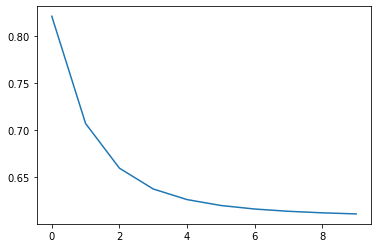

In [36]:
h='H2'
X_train,X_test,y_train,y_test=runner('configs/'+h+'.yaml')

loss_avg=[]
for i in range(1):
    
    a,b,loss_l=MC_EMtrain(X_train,y_train,Markov_init='',lamb_init='',perturb=0,steps=10,break_thr=0.0001)
    a[0,:]=np.zeros(a.shape[0])
    a[0,0]=1
    a[1,:]=np.zeros(a.shape[0])
    a[1,1]=1
    np.save('rho'+h,a)
    np.save('lamb'+h,b)
    plt.plot(loss_l)
    print('train error'+str(loss_l[-1]))
    Vec_Len=len(X_test[0])
    SAMPLE_AMOUNT=len(X_test[:,0])
    PROB_PRED = np.zeros((SAMPLE_AMOUNT,Vec_Len))
    for i in range(SAMPLE_AMOUNT):
                        assort = X_test[i]            
                        PROB_PRED[i] = Absorbing_Calculator(b, a, assort)
    loss = sklearn.metrics.log_loss(y_test, PROB_PRED)
    loss_l.append(loss)
    print('test error'+str(loss_l[-1]))
    loss_avg.append(loss_l[-1])

C:\Users\Hanzhaoeng\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in double_scalars


0
1
2
3
4
5
6
7
8
9
train errortensor(0.8207, dtype=torch.float64)
test error0.6557058793651979


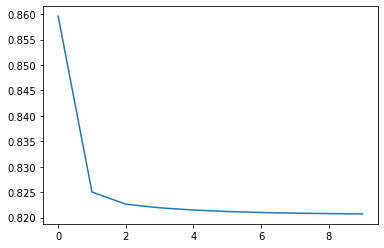

In [40]:
h='H4'
X_train,X_test,y_train,y_test=runner('configs/'+h+'.yaml')

loss_avg=[]
for i in range(1):
    
    a,b,loss_l=MC_EMtrain(X_train,y_train,Markov_init='',lamb_init='',perturb=0,steps=10,break_thr=0.0001)
    a[0,:]=np.zeros(a.shape[0])
    a[0,0]=1
    a[1,:]=np.zeros(a.shape[0])
    a[1,1]=1
    np.save('rho'+h,a)
    np.save('lamb'+h,b)
    plt.plot(loss_l)
    print('train error'+str(loss_l[-1]))
    Vec_Len=len(X_test[0])
    SAMPLE_AMOUNT=len(X_test[:,0])
    PROB_PRED = np.zeros((SAMPLE_AMOUNT,Vec_Len))
    for i in range(SAMPLE_AMOUNT):
                        assort = X_test[i]            
                        PROB_PRED[i] = Absorbing_Calculator(b, a, assort)
    loss = sklearn.metrics.log_loss(y_test, PROB_PRED)
    loss_l.append(loss)
    print('test error'+str(loss_l[-1]))
    loss_avg.append(loss_l[-1])

In [49]:
a

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.07239344, 0.16179615, 0.00838706, 0.09084776, 0.07041147,
        0.374123  , 0.22204111],
       [0.00289328, 0.26389262, 0.0928423 , 0.23341189, 0.17931671,
        0.01502188, 0.21262131],
       [0.20482023, 0.02165946, 0.2105629 , 0.01265097, 0.17588514,
        0.2522477 , 0.12217361],
       [0.01741243, 0.24622224, 0.1213214 , 0.16576189, 0.17223532,
        0.21459923, 0.06244751],
       [0.07778024, 0.09460246, 0.27065806, 0.32393424, 0.0933835 ,
        0.05529269, 0.08434882]])

C:\Users\Hanzhaoeng\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in double_scalars


0
1
2
3
4
5
6
7
8
9
train errortensor(0.7673, dtype=torch.float64)
test error0.6551399776070241


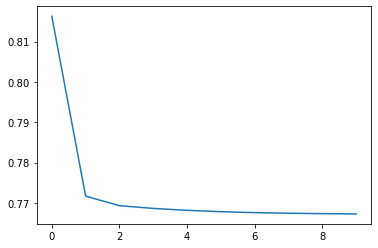

In [48]:
h='H5'
X_train,X_test,y_train,y_test=runner('configs/'+h+'.yaml')

loss_avg=[]
for i in range(1):
    
    a,b,loss_l=MC_EMtrain(X_train,y_train,Markov_init='',lamb_init='',perturb=0,steps=10,break_thr=0.0001)
    a[0,:]=np.zeros(a.shape[0])
    a[0,0]=1
    a[1,:]=np.zeros(a.shape[0])
    a[1,1]=1
    np.save('rho'+h,a)
    np.save('lamb'+h,b)
    plt.plot(loss_l)
    print('train error'+str(loss_l[-1]))
    Vec_Len=len(X_test[0])
    SAMPLE_AMOUNT=len(X_test[:,0])
    PROB_PRED = np.zeros((SAMPLE_AMOUNT,Vec_Len))
    for i in range(SAMPLE_AMOUNT):
                        assort = X_test[i]            
                        PROB_PRED[i] = Absorbing_Calculator(b, a, assort)
    loss = sklearn.metrics.log_loss(y_test, PROB_PRED)
    loss_l.append(loss)
    print('test error'+str(loss_l[-1]))
    loss_avg.append(loss_l[-1])